# Agent-baseret simulation af et simpelt marked

Først importeres de nødvendige biblioteker:

In [360]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 5)
import pandas as pd
import numpy as np
import math
import importlib
import marketlib
importlib.reload(marketlib)

<module 'marketlib' from '/Users/jzk870/Dropbox/Work/Dissemination/Dataekspeditioner/Code/market_competition/marketlib.py'>

## Markedsparametre

In [361]:
# Alpha: hvor meget forbrugere vil efterspørge, hvis prisen er nul
alpha = 10.5

# Beta: hældning på demand-kurve, hvor stor effekt prisen på varen har på efterspørgslen
beta = 1.75

# Theta: afgører hvilken indflydelse det har at prisen afviger fra markedsgennemsnittet
theta = 1.45833

# Marginal produktionsomkostninger
c = 8

# Saml model parametre 
mp = {'alpha': alpha, 'beta': beta, 'theta': theta, 'c': c}

# Hvor mange tids-skridt skal simuleringen køre?
time_steps = 500

# Antal agenter (bliver overskrevet hvis man anvender de empiriske agenter alene)
num_agents = 200

## Agent parametre

In [362]:
# Hvor mange penge har hver agent når simulationen går i gang?
initial_endowment = 500

# Hvilket produktionsniveau starter agenterne på?
initial_production = 7.5

# Hvilken pris sætter agenterne i starten?
initial_price = 11

# Angiv andel af agenterne, der følger flokken i prissætning
share_herding = 0.3
num_agents_herding = int(share_herding * num_agents)
num_agents_best_response = int((1 - share_herding)*num_agents)


# Hent parametre til agenters adfærd - best response
pe_params_br, p_params_br, q_params_br, num_agents_best_response = marketlib.get_parameters(mp,
                                                                            param_type = "best_response",
                                                                            num_agents = num_agents_best_response)

# Parametre til agenters adfærd - herding
pe_params_h, p_params_h, q_params_h, num_agents_herding = marketlib.get_parameters(mp,
                                                                            param_type = "herding",
                                                                            num_agents = num_agents_herding)

# Saml best response parametre og herding parametre i 1 data frame for hver parameter klasse
pe_params = pd.concat([pe_params_br, pe_params_h])
p_params = pd.concat([p_params_br, p_params_h])
q_params = pd.concat([q_params_br, q_params_h])

## Beregning af efterspørgsel

Efterspørgsels-funktionen for markedet

In [363]:
def demand(price, market_price):
    return alpha - beta * price + theta * market_price

## Opret agenterne

In [364]:
def create_agents(n):
    # Tom liste af agenter
    agents = []

    # Opret så mange agenter vi har brug for
    # og gem dem i listen
    for i in range(n):
        agent = marketlib.Producer(initial_price,
                                   initial_production,
                                   initial_endowment,
                                   c = c,
                                   pe = pe_params.iloc[i],
                                   p = p_params.iloc[i],
                                   q = q_params.iloc[i])
        agents.append(agent)
    return agents

## Beskriv ét trin af simuleringen

In [365]:
def simulation_step(agents, t, mean_prices):
    # Lad agenterne sætte pris og produktionsniveau
    for agent in agents:
        agent.set_price(mean_prices[t-1], mean_prices[t-2])
        agent.set_production_level()

    # Aflæs priser og beregn markedspris
    prices_t = [a.price for a in agents]
    mean_price_t = np.nanmean(prices_t)

    # Lad agenter observere faktisk efterspørgsel
    for agent in agents:
        d = demand(agent.price, mean_price_t)
        agent.observe_demand(d)
        agent.calculate_profit(d)
        agent.update_price_adjustment()

    return prices_t, mean_price_t

## Kør simuleringen
Simpleste måde at køre simuleringen, hvor vi kun gemmer gennemsnitspriserne, og plotter dem.

In [366]:
# Da agenterne er bagudskuende mht observerede priser er det nødvendigt at definere en kunstig 
# 'forhistorie' til simulationen bestående af brugerdefinerede priser i en antal perioder
t_prehist = 3

# Initier data frame til gennemsnitlige priser
mean_prices = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])
mean_prices[0:t_prehist] = initial_price

# Skab agenter
agents = create_agents(num_agents)

# Kør simulering
for t in range(t_prehist, time_steps):
    prices_t, mean_price_t = simulation_step(agents, t, mean_prices.iloc[:,0])
    
    # Gem gennemsnitsprisen
    mean_prices.iloc[t] = mean_price_t

# Vis gennemsnitlig pris over tid

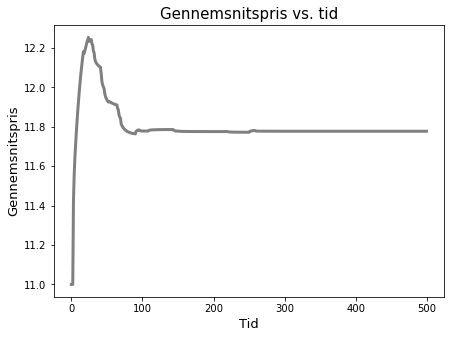

In [367]:
mean_prices.plot(legend = None, color = 'grey', alpha = 1, linewidth = 3)
plt.title("Gennemsnitspris vs. tid", weight = 'roman', size = 15)
plt.xlabel('Tid', weight = 'roman', size = 13)
plt.ylabel('Gennemsnitspris', weight = 'roman', size = 13);

## Kør simuleringen - og gem flere informationer

Kør simuleringen igen, denne gang gemmer vi meget mere information, for at kunne plotte de enkelte agenters opførsel, samt opførslen 

In [368]:
# Opret tabeller til at gemme hver agents pris/produktion/profit, som
# vi kan bruge når vi skal lave grafer
cols = ["agent" + str(i) for i in range(num_agents)]

price_df = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
quantity_df = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
profit_df = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)

mean_productions = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])
mean_prices = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])
mean_profits = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])
mean_productions[0:3] = initial_production
mean_prices[0:3] = initial_price
mean_profits[0:3] = 0

agents = create_agents(num_agents)
    
for t in range(3, time_steps):
    # Kør simulering
    prices_t, mean_price_t = simulation_step(agents, t, mean_prices.iloc[:,0])

    # Aflæs produktion og profit fra agenter
    quantities_t = [a.quantity for a in agents]
    profits_t = [a.profit for a in agents]

    # Beregn gennemsnitlig produktion og profit
    mean_production_t = np.nanmean(quantities_t)
    mean_profit_t = np.nanmean(profits_t)
    
    # Gem agenters profit, priser og produktionsmængder til plots
    profit_df.loc[t] = profits_t
    price_df.loc[t] = prices_t
    quantity_df.loc[t] = quantities_t

    mean_productions.iloc[t] = mean_production_t
    mean_prices.iloc[t] = mean_price_t
    mean_profits.iloc[t] = mean_profit_t
        
    #print(f"{t}: Mean price: {mean_price_t:.2f}  -  Mean production: {mean_production_t:.2f}")

## Plot resultater

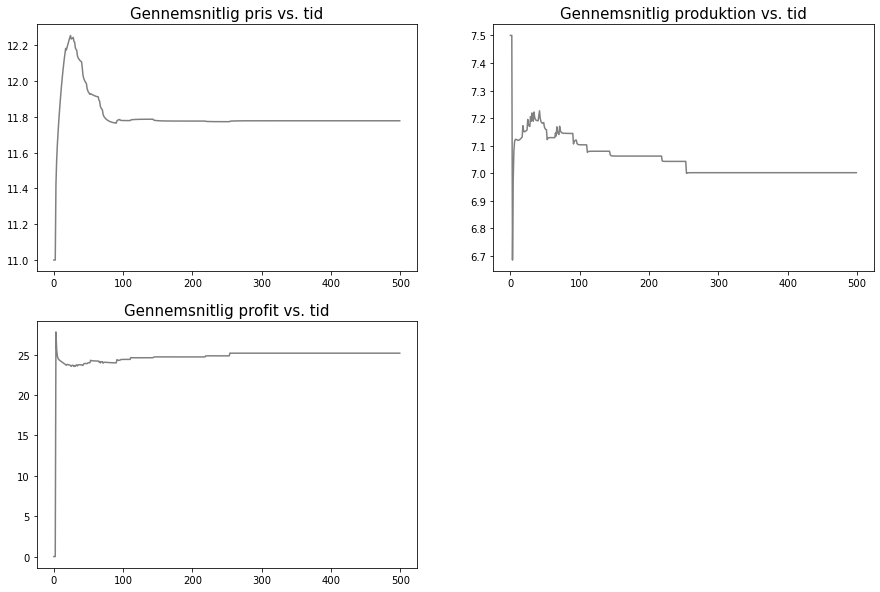

In [369]:
# Initier subplots og sæt figurstørrelse
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
fig.set_size_inches(15, 10)

# Begynd plots fra periode t_0. Kan sættes til 0 og op. 
# Anvendelig da simulationen er mere volatil i begyndelsen pga start betingelserne.
t_0 = 0

# Indsæt plot for alle agenternes individuelle historik
mean_prices[t_0:].plot(ax = axes[0,0], legend = None, color = 'grey', alpha = 1)
axes[0, 0].set_title('Gennemsnitlig pris vs. tid', weight = 'roman', size = 15)
#axes[0, 0].set_ylim(9,15)

mean_productions[t_0:].plot(ax = axes[0,1], legend = None, color = 'grey', alpha = 1)
axes[0, 1].set_title('Gennemsnitlig produktion vs. tid', weight = 'roman', size = 15)
#axes[0, 1].set_ylim(0,20)

mean_profits[t_0:].plot(ax = axes[1,0], legend = None, color = 'grey', alpha = 1)
axes[1, 0].set_title('Gennemsnitlig profit vs. tid', weight = 'roman', size = 15)
#axes[1, 0].set_ylim(-20,100)

# Tilpas og vis figur
fig.delaxes(axes[1,1])
plt.show()

## Plot kurver for hver enkelt agent

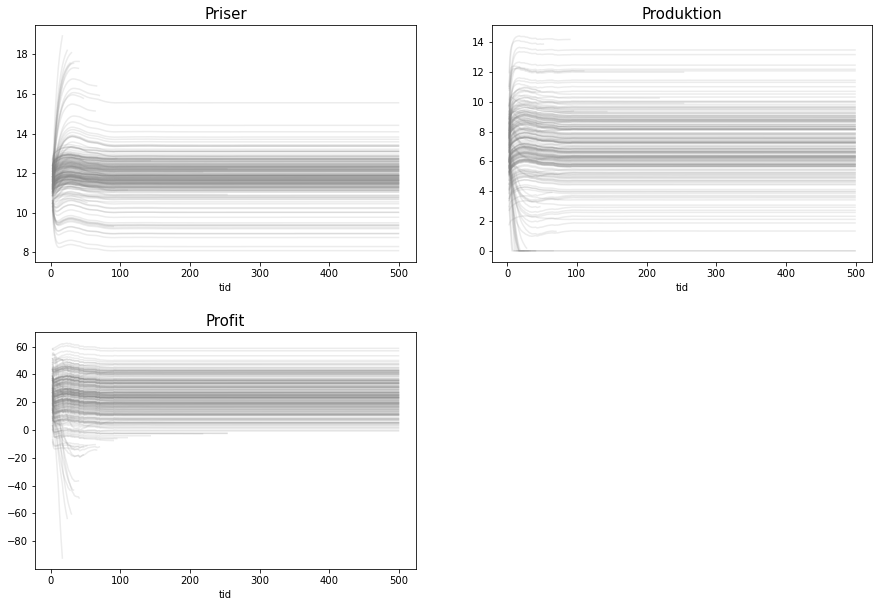

In [370]:
# Initier subplots og sæt figurstørrelse
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
fig.set_size_inches(15, 10)

# Indsæt plot for alle agenternes individuelle historik
price_df.plot(ax = axes[0,0], legend = None, color = 'grey', alpha = 0.15)
axes[0, 0].set_title('Priser', weight = 'roman', size = 15)
# axes[0, 0].set_ylim(9,15)
axes[0, 0].set_xlabel('tid')

quantity_df.plot(ax = axes[0,1], legend = None, color = 'grey', alpha = 0.15)
axes[0, 1].set_title('Produktion', weight = 'roman', size = 15)
# axes[0, 1].set_ylim(0,20)
axes[0, 1].set_xlabel('tid')

profit_df.plot(ax = axes[1,0], legend = None, color = 'grey', alpha = 0.15)
axes[1, 0].set_title('Profit', weight = 'roman', size = 15)
# axes[1, 0].set_ylim(-20,100)
axes[1, 0].set_xlabel('tid')

# Tilpas og vis figur
fig.delaxes(axes[1,1])
plt.show()


# Note: vi kan tilføje en figur med antallet af tilbageværende ikke-konkursramte agenter til tidspunkt t

In [ ]:
# Gammel plotting kode

## Markedspris over tid
#mean_prices.plot(legend = None)
#plt.title("Markedspris vs. tid")
#plt.xlabel('t')
#plt.ylabel('markedspris')

## Produktion over tid
#mean_productions.plot(legend = None)
#plt.title('Gennemsnitlig produktion vs. tid')
#plt.xlabel('t')
#plt.ylabel('produktion')

## Profit over tid
#mean_profits.plot(legend = None)
#plt.title('Gennemsnitlig profit vs. tid')
#plt.xlabel('t')
#plt.ylabel('profit')

# Figurer der ligger hver for sig
# price_df.plot(legend = None, color = 'grey', alpha = 0.2);
# plt.title("Priser");
# quantity_df.plot(legend = None, color = 'grey', alpha = 0.2)
# plt.title("Produktion")
# profit_df.plot(legend = None, color = 'grey', alpha = 0.2);
# plt.title("Profit");

## Gentag simulering

In [342]:
# Antal gentagelser
repetitions = 50

cols = ["r" + str(i) for i in range(repetitions)]
mean_productions = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
mean_prices = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
mean_profits = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)

mean_productions[0:3] = initial_production
mean_prices[0:3] = initial_price
mean_profits[0:3] = 0

for r in range(repetitions):
    agents = create_agents(num_agents)
    
    for t in range(3, time_steps):
        prices_t, mean_price_t = simulation_step(agents, t, mean_prices.iloc[:,r])

        # Aflæs produktion og profit fra agenter
        #quantities_t = marketlib.get_attr(agents, "quantity")
        #profits_t = marketlib.get_attr(agents, "profit")
        quantities_t = [a.quantity for a in agents]
        profits_t = [a.profit for a in agents]
    
        # Beregn gennemsnitlig produktion og profit
        mean_production_t = np.nanmean(quantities_t)
        mean_profit_t = np.nanmean(profits_t)
        
        # Gem data til plots
        mean_productions.iloc[t,r] = mean_production_t
        mean_prices.iloc[t,r] = mean_price_t
        mean_profits.iloc[t,r] = mean_profit_t
        
    print(f"{r}:   Mean price: {mean_price_t:.2f}  -  Mean production: {mean_production_t:.2f}")

0:   Mean price: 11.99  -  Mean production: 6.82
1:   Mean price: 11.99  -  Mean production: 6.82
2:   Mean price: 11.99  -  Mean production: 6.82
3:   Mean price: 11.99  -  Mean production: 6.82
4:   Mean price: 11.99  -  Mean production: 6.82
5:   Mean price: 11.99  -  Mean production: 6.82
6:   Mean price: 11.99  -  Mean production: 6.82
7:   Mean price: 11.99  -  Mean production: 6.82
8:   Mean price: 11.99  -  Mean production: 6.82
9:   Mean price: 11.99  -  Mean production: 6.82
10:   Mean price: 11.99  -  Mean production: 6.82
11:   Mean price: 11.99  -  Mean production: 6.82
12:   Mean price: 11.99  -  Mean production: 6.82
13:   Mean price: 11.99  -  Mean production: 6.82
14:   Mean price: 11.99  -  Mean production: 6.82
15:   Mean price: 11.99  -  Mean production: 6.82
16:   Mean price: 11.99  -  Mean production: 6.82
17:   Mean price: 11.99  -  Mean production: 6.82
18:   Mean price: 11.99  -  Mean production: 6.82
19:   Mean price: 11.99  -  Mean production: 6.82
20:   Mean

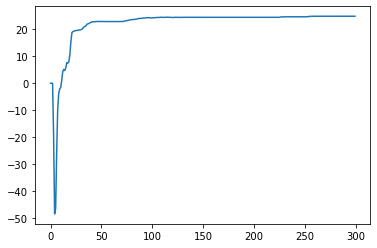

In [128]:
mean_profits.mean(1).plot()

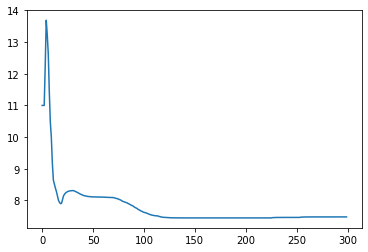

In [129]:
mean_prices.mean(1).plot()

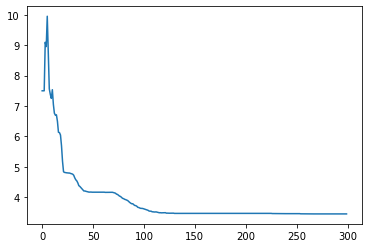

In [130]:
mean_productions.mean(1).plot()

statistics = mean_prices.agg(['mean', 'count', 'std'], axis=1)
print(statistics)
print('-'*30)

ci95_hi = []
ci95_lo = []

for i in statistics.index:
    m, c, s = statistics.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

statistics['ci95_hi'] = ci95_hi
statistics['ci95_lo'] = ci95_lo
statistics.loc[:,["ci95_hi", "mean", "ci95_lo"]].plot()

In [341]:
α = 10.5
β = 1.75
θ = 1.45833
c = 8
θ_p = θ/(2*β)
α_p = α/(2*β)
n = 10

def p_mc(c_in): 
    return (1/(1-θ_p))*(α_p + c_in/2)

def p_ne(n):
    θ_n = (θ*(n-1))/(2*(n*β-θ))
    α_n = (α*n)/(2*(n*β-θ))
    return (1/(1-θ_n))*(α_n + c/2)

def p_br(p_bar):
    return α_p + c/2 + θ_p*p_bar

c1 = 8
c2 = 10


print("Teoretisk monopolitisk pris når c = 8 : ", p_mc(c1))
print("Teoretisk stigning i pris når c stiger fra 8 til 10: ", p_mc(c2) - p_mc(c1))


Teoretisk pris når c = 8 :  11.999980408195249
Teoretisk stigning i pris når c stiger fra 8 til 10:  1.7142829154564652


In [359]:
print(list(map(lambda x: x + ' x', ['a', 'b'])))

['a x', 'b x']
